In [1]:
# from tbparse import SummaryReader
%matplotlib inline
import os
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()

In [2]:
"""
Provides a `SummaryReader` class that will read all tensorboard events and
summaries in a directory contains multiple event files, or a single event file.
"""

# pylint: disable=C0302
import copy
import os
from collections import defaultdict
from types import ModuleType
from typing import Any, Dict, List, Optional, Set, Tuple, Union, cast

import numpy as np
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import (
    AUDIO, COMPRESSED_HISTOGRAMS, HISTOGRAMS, IMAGES, SCALARS,
    STORE_EVERYTHING_SIZE_GUIDANCE, TENSORS, AudioEvent, EventAccumulator,
    HistogramEvent, ImageEvent, ScalarEvent, TensorEvent)
from tensorboard.plugins.hparams.plugin_data_pb2 import HParamsPluginData
try:
    import tensorflow
except ImportError:
    tensorflow = None

# pylint: disable=W0105
"""
from tensorboard.backend.event_processing.event_accumulator import (
    AUDIO, COMPRESSED_HISTOGRAMS, GRAPH, HISTOGRAMS, IMAGES, META_GRAPH,
    RUN_METADATA, SCALARS, STORE_EVERYTHING_SIZE_GUIDANCE, TENSORS, AudioEvent,
    CompressedHistogramEvent, EventAccumulator, HistogramEvent, ImageEvent,
    ScalarEvent, TensorEvent)
"""

HPARAMS = 'hparams'
TEXT = 'text'
PLUGIN_TAGS = {HPARAMS, TEXT}
PLUGIN_RAW_TAGS = {
    "hparams/exp": "_hparams_/experiment",
    "hparams/ssi": "_hparams_/session_start_info",
    "hparams/sei": "_hparams_/session_end_info",
    TEXT: "/text_summary",
}

MINIMUM_SIZE_GUIDANCE = {
    COMPRESSED_HISTOGRAMS: 1,
    IMAGES: 1,
    AUDIO: 1,
    SCALARS: 1,
    HISTOGRAMS: 1,
    TENSORS: 1,
}

ALL_EVENT_TYPES = {SCALARS, TENSORS, HISTOGRAMS, IMAGES, AUDIO, HPARAMS, TEXT}
REDUCED_EVENT_TYPES = {SCALARS, HISTOGRAMS, HPARAMS}
ALL_EXTRA_COLUMNS = {'dir_name', 'file_name', 'wall_time', 'min', 'max', 'num',
                     'sum', 'sum_squares', 'width', 'height', 'content_type',
                     'length_frames', 'sample_rate'}


# pylint: disable=R0904
class SummaryReader():
    """
    Creates a `SummaryReader` that reads all tensorboard events and summaries
    stored in a event file or a directory containing multiple event files.
    """

    def __init__(self, log_path: str, *, pivot=False, extra_columns=None,
                 event_types=None):
        """The constructor of SummaryReader. Columns contains `step`, `tag`, \
           and `value` by default.

        :param log_path: Load directory location, or load file location.
        :type log_path: str

        :param pivot: Returns long format DataFrame by default, \
                returns wide format DataFrame if set to True. If there are \
                multiple values per step with the same tag, the values are \
                merged into a list.
        :type pivot: bool

        :param extra_columns: Specifies extra columns, defaults to `None`.

                - dir_name:  add a column that contains the relative \
                             directory path.
                - file_name: add a column that contains the relative \
                             event file path.
                - wall_time: add a column that stores the event timestamp.
                - min (histogram): the min value in the histogram.
                - max (histogram): the max value in the histogram.
                - num (histogram): the number of values in the histogram.
                - sum (histogram): the sum of all values in the histogram.
                - sum_squares (histogram): the sum of squares for all values \
                                           in the histogram.
                - width (image): the width of the image.
                - height (image): the height of the image.
                - content_type (audio): the content type of the audio.
                - length_frames (audio): the length of the audio.
                - sample_rate (audio): the sampling rate of the audio.
        :type extra_columns: Set[{'dir_name', 'file_name', 'wall_time', \
                'min', 'max', 'num', 'sum', 'sum_squares', 'width', 'height', \
                'content_type', 'length_frames', 'sample_rate'}]

        :param event_types: Specifies the event types to parse, \
            defaults to all event types.
        :type event_types: Set[{'scalars', 'tensors', 'histograms', 'images', \
            'audio', 'hparams', 'text'}]
        """
        self._log_path: str = log_path
        """Load directory location, or load file location."""
        self._extra_columns: Set[str] = (extra_columns or set()).copy()
        """Specifies additional required columns."""
        if not isinstance(self._extra_columns, set):
            raise ValueError(f"`columns` should be a {set} instead of \
                              {str(type(self._extra_columns))}")
        diff = self._extra_columns - ALL_EXTRA_COLUMNS
        if len(diff) > 0:
            raise KeyError(f"Invalid columns entries: {diff}")
        self._pivot: bool = pivot
        """Determines whether the DataFrame is stored in wide format."""
        self._event_types: Set[str] = (event_types or ALL_EVENT_TYPES).copy()
        """Specifies the event types to parse."""
        if tensorflow is None:
            self._event_types = (event_types or REDUCED_EVENT_TYPES).copy()
        if not isinstance(self._event_types, set):
            raise ValueError(f"`event_types` should be a {set} instead of \
                              {str(type(self._event_types))}")
        diff = self._event_types - ALL_EVENT_TYPES
        if len(diff) > 0:
            raise KeyError(f"Invalid event types: {diff}")
        self._children: Dict[str, 'SummaryReader'] = {}
        """Holds a list of references to the `SummaryReader` children."""

        self._tags: Optional[Dict[str, List[str]]] = None
        """Stores a dictionary contatining a list of parsed tag names for each
        event type."""
        self._events: Dict[str, pd.DataFrame] = self._make_empty_dict(None)
        """Stores a `pandas.DataFrame` containing all events."""

        if not os.path.exists(self.log_path):
            raise ValueError(f"File or directory not found: {self.log_path}")
        if os.path.isfile(self.log_path):
            # Note: tensorflow.python.summary.summary_iterator is less
            #       straightforward, so we use EventAccumulator instead.
            size_guidance = MINIMUM_SIZE_GUIDANCE.copy()
            for e in self._event_types:
                size_guidance[e] = 0  # store everything
            event_acc = EventAccumulator(self.log_path, size_guidance)
            event_acc.Reload()
            self._tags = self._make_empty_dict([])
            for e in self._event_types:
                self._parse_events(e, event_acc=event_acc)
        else:
            # Populate children
            print(self.log_path)
            for filename in sorted(os.listdir(self.log_path)):
                filepath = os.path.join(self.log_path, filename)
                r = SummaryReader(filepath,
                                  pivot=self._pivot,
                                  extra_columns=self._extra_columns,
                                  event_types=self._event_types)
                self._children[filename] = r

    @property
    def log_path(self) -> str:
        """Load directory location, or load file location.

        :return: A directory path or file path.
        :rtype: str
        """
        return self._log_path

    @property
    def tags(self) -> Dict[str, List[str]]:
        """Returns a dictionary contatining a list of parsed tag names for each
        event type.

        :return: A `{eventType: ['list', 'of', 'tags']}` dictionary.
        :rtype: Dict[str, List[str]]
        """
        return cast(Dict[str, List[str]], self.get_tags())

    def get_tags(self, event_type: str = None) -> \
            Union[List[str], Dict[str, List[str]]]:
        """Returns a list of tag names for the specified event type. If
        `event_type` is None, return a dictionary containing a list of tag
        names for each event type.

        :param event_type: the event type to retrieve, None means return all, \
        defaults to None.
        :type event_type: {None, 'scalars', 'tensors', 'histograms', \
            'images', 'audio', 'hparams', 'text'}, optional
        :raises ValueError: if `event_type` is unknown.
        :return: A `['list', 'of', 'tags']` list, or a \
            `{eventType: ['list', 'of', 'tags']}` dictionary.
        :rtype: List[str] | Dict[str, List[str]]
        """
        if event_type not in {None}.union(ALL_EVENT_TYPES):
            raise ValueError(f"Unknown event_type: {event_type}")
        if self._tags is not None:
            # Leaf node returns directly
            if event_type is not None:
                return self._tags[event_type].copy()
            return copy.deepcopy(self._tags)
        # Non-leaf node collects children's tags then return
        tags = self._make_empty_dict([])
        if event_type is not None:
            # Only collect the specified event type
            tags = {event_type: tags[event_type]}
        for t in list(tags.keys()):
            for c in self.children.values():
                # Collect children's tags
                tags[t] += c.get_tags(t)
            # Deduplicate same tag names
            tags[t] = list(dict.fromkeys(tags[t]))
        if event_type is not None:
            return tags[event_type]
        return tags

    @staticmethod
    def _merge_values(s: pd.Series):
        """Merge multiple values. Ignore NaNs, concat others."""
        # Does not support python3.6 since DataFrame does not fully support
        # `np.ndarray` as an element in cell. See the following:
        # lib/python3.6/site-packages/pandas/core/groupby/generic.py:482
        # Python 3.6 EOL: 2021-12-23 (https://www.python.org/downloads/)
        try:
            assert isinstance(s, pd.Series)
            if len(s) == 1:
                return s  # Return directly if no merging is needed
            lst = []
            for xx in s:
                if isinstance(xx, list):
                    lst.extend(xx)
                elif np.isscalar(xx):
                    if not pd.isnull(xx):
                        lst.append(xx)
                else:
                    lst.append(xx)
            if len(lst) == 0:
                return np.nan
            if len(lst) == 1:
                return lst[0]
            return lst
        except Exception as error:
            # Pandas ignores some errors by default
            raise ValueError from error

    def get_events(self, event_type: str) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all `event_type` events \
        under `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :type event_type: {'scalars', 'tensors', 'histograms', 'images', \
            'audio', 'hparams', 'text'}.
        :raises ValueError: if `event_type` is unknown.
        :return: A `DataFrame` storing all `event_type` events.
        :rtype: pandas.DataFrame
        """
        if event_type not in ALL_EVENT_TYPES:
            raise ValueError(f"Unknown event_type: {event_type}")
        if event_type not in REDUCED_EVENT_TYPES and tensorflow is None:
            self._get_tensorflow()  # raise error
        if event_type not in self._event_types:
            raise ValueError(f"event_type is ignored by user: {event_type}")
        group_columns: List[Any] = list(filter(
            lambda x: x in self._extra_columns, ['dir_name', 'file_name']))
        dfs = []
        if os.path.isfile(self.log_path):
            # Leaf node appends events directly
            dfs.append(self._events[event_type])
        else:
            # Non-leaf node collects children's events
            for child in self._children.values():
                df = child.get_events(event_type)
                # iteratively prepend dir_name
                if 'dir_name' in df and os.path.isdir(child.log_path):
                    dir_name = os.path.basename(child.log_path)
                    df_cond = (df['dir_name'] == '')
                    df.loc[df_cond, 'dir_name'] = dir_name
                    df.loc[~df_cond, 'dir_name'] = \
                        dir_name + '/' + df.loc[~df_cond, 'dir_name']
                dfs.append(df)
        dfs = list(filter(lambda x: x is not None, dfs))
        if len(dfs) == 0:
            return pd.DataFrame()
        df_stacked = pd.concat(dfs, ignore_index=True)
        if df_stacked.empty:
            return pd.DataFrame()
        if not self._pivot:
            group_columns += ['tag']

        group_columns += ['step']
        # Don't sort by wall_time, since there is only a single value per step
        # in most cases
        group_columns = list(filter(
            lambda x: x in df_stacked.columns, group_columns))
        df_stacked.sort_values(group_columns, ignore_index=True, inplace=True)
        if not self._pivot:
            return df_stacked
        if len(group_columns) == 0:
            # merge all rows
            group_columns = [True] * len(df_stacked)
        # Merge if there are multiple values per step with the same tag
        grouped = df_stacked.groupby(group_columns, sort=False)
        df = grouped.aggregate(self._merge_values)
        df.reset_index(inplace=True)
        # Reorder columns
        middle_columns = list(filter(
            lambda x: x not in
            ['step', 'wall_time', 'dir_name', 'file_name'],
            df_stacked.columns))
        middle_columns = sorted(middle_columns)  # sort tags
        columns = ['step'] + middle_columns + \
            ['wall_time', 'dir_name', 'file_name']
        columns = list(filter(lambda x: x in df_stacked.columns, columns))
        return df[columns]  # reorder since values are merged

    @property
    def scalars(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all scalar events under \
        `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all scalar events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(SCALARS)

    @property
    def tensors(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all tensor events under \
        `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all tensor events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(TENSORS)

    @property
    def histograms(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all histograms events
        under `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all histograms events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(HISTOGRAMS)

    @property
    def images(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all images events under \
        log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all images events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(IMAGES)

    @property
    def audio(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all audio events under \
        `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all audio events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(AUDIO)

    @property
    def hparams(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all hparams events
        under `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all hparams events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(HPARAMS)

    @property
    def text(self) -> pd.DataFrame:
        """Construct a `pandas.DataFrame` that stores all text events
        under `log_path`. Some processing is performed when evaluating this \
        property. Therefore you may want to store the results and reuse it \
        for better performance.

        :return: A `DataFrame` storing all hparams events.
        :rtype: pandas.DataFrame
        """
        return self.get_events(TEXT)

    @staticmethod
    def tensor_to_histogram(tensor: np.ndarray) -> Dict[str, Any]:
        """Convert a tensor to histogram dictionary.

        :param tensor: A `[['left edge', 'right edge', 'count']]` \
        list. The range of the bucket is [lower, upper)
        :type tensor: np.ndarray
        :return: A `{hist_data_name: hist_data}` dictionary.
        :rtype: Dict[str, Any]
        """
        limits = [tensor[0][0]] + list(map(lambda x: x[1], tensor))
        counts = [0] + list(map(lambda x: x[2], tensor))
        assert len(limits) == len(tensor) + 1
        assert len(limits) == len(counts)
        d = {
            'limits': np.array(limits),
            'counts': np.array(counts),
            'min': limits[0],
            'max': limits[-1],
            'num': np.sum(counts),
            'sum': np.nan,
            'sum_squares': np.nan,
        }
        return d

    @staticmethod
    def buckets_to_histogram_dict(lst: np.ndarray) -> Dict[str, Any]:
        """Convert a list of buckets to histogram dictionary. \
        (deprecated, use `tensor_to_histogram` instead)

        :param lst: A `[['bucket lower', 'bucket upper', 'bucket count']]` \
        list. The range of the bucket is [lower, upper)
        :type lst: np.ndarray
        :return: A `{hist_data_name: hist_data}` dictionary.
        :rtype: Dict[str, Any]
        """
        return SummaryReader.tensor_to_histogram(lst)

    @staticmethod
    def _get_tensorflow() -> ModuleType:
        if tensorflow is not None:
            return tensorflow
        raise ModuleNotFoundError("No module named 'tensorflow'. " +
              "Please install 'tensorflow' or 'tensorflow-cpu'.")

    @staticmethod
    def tensor_to_image(tensor: np.ndarray) -> Dict[str, Any]:
        """Convert a tensor to image dictionary.

        :param tensor: A `['width', 'height', 'encoded image', ...]` list.
        :type tensor: np.ndarray
        :return: A `{image_data_name: image_data}` dictionary.
        :rtype: Dict[str, Any]
        """
        # pylint: disable=C0103
        tf = SummaryReader._get_tensorflow()
        lst = list(map(tf.image.decode_image, tensor[2:]))
        lst = list(map(lambda x: x.numpy(), lst))
        image = np.stack(lst, axis=0)
        if image.shape[0] == 1:
            image = image.squeeze(axis=0)
        d = {
            'image': image,
            'width': int(tensor[0]),
            'height': int(tensor[1]),
        }
        return d

    @staticmethod
    def tensor_to_audio(tensor: np.ndarray) -> Dict[str, Any]:
        """Convert a audio to audio dictionary.

        :param tensor: A `[['encoded audio', b''], ...]` list.
        :type tensor: np.ndarray
        :return: A `{audio_data_name: audio_data}` dictionary.
        :rtype: Dict[str, Any]
        """
        # pylint: disable=C0103
        tf = SummaryReader._get_tensorflow()
        assert tensor[:, 1].tolist() == [b''] * tensor.shape[0]
        lst = list(map(tf.audio.decode_wav, tensor[:, 0]))
        audio_lst = list(map(lambda x: x[0].numpy(), lst))
        sample_rate_lst = list(map(lambda x: x[1].numpy(), lst))
        audio = np.stack(audio_lst, axis=0)
        sample_rate = np.stack(sample_rate_lst, axis=0)
        length = audio.shape[1]
        if audio.shape[0] == 1:
            audio = audio.squeeze(axis=0)
            sample_rate = sample_rate.squeeze(axis=0)
        d = {
            'audio': audio,
            'content_type': 'audio/wav',
            'length_frames': length,
            'sample_rate': sample_rate,
        }
        return d

    @staticmethod
    def histogram_to_pdf(counts: np.ndarray, limits: np.ndarray,
                         x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Given an array of `x` (values), returns the pair (`c`, `y`), which
        are the corresponding `c` (bucket center) and the linear interpolation
        of its `y` (probability density in bucket), given the bucket counts
        and limits.

        :param counts: The number of values inside the buckets. The first \
            value must be zero.
        :type counts: np.ndarray
        :param limits: The (right) edges of the buckets. The first value is \
            the left edge of the first bucket.
        :type limits: np.ndarray
        :param x: The input values of x.
        :type x: np.ndarray
        :return: The tuple containing the bucket center and the \
            probability density of the bucket.
        :rtype: Tuple[np.ndarray, np.ndarray]
        """
        y = SummaryReader.histogram_to_cdf(counts, limits, x)
        center = (x[1:]+x[:-1])/2
        density = (y[1:]-y[:-1])/(x[1:]-x[:-1])
        return center, density

    @staticmethod
    def histogram_to_cdf(counts: np.ndarray, limits: np.ndarray,
                         x: np.ndarray) -> np.ndarray:
        """Given an array of `x` (values), returns the linear interpolation of
        its corresponding `y` (cumulative probability), given the bucket counts
        and limits.

        :param counts: The number of values inside the buckets. The first \
            value must be zero.
        :type counts: np.ndarray
        :param limits: The (right) edges of the buckets. The first value is \
            the left edge of the first bucket.
        :type limits: np.ndarray
        :param x: The input values of x coordinates.
        :type x: np.ndarray
        :return: `y`, the cumulative probability at values `x`.
        :rtype: np.ndarray
        """
        assert len(counts) == len(limits)
        counts = np.array(counts)
        limits = np.array(limits)
        n = np.sum(counts)
        x = np.array(x)
        # x must be increasing
        assert np.all(np.diff(x) > 0)

        cumsum = np.cumsum(counts)
        assert len(cumsum) == len(limits)

        y: List[int] = []
        # Calculate y[i], where x[i] <= limits[0]
        i = 0
        while i < len(x) and x[i] <= limits[0]:
            y.append(0)
            i += 1
        # Calculate y[i], where limits[0] < x[i] <= limits[-1]
        idx = 0
        while i < len(x) and idx + 1 < len(limits):
            if limits[idx+1] < x[i]:
                idx += 1
                continue
            lower = limits[idx]
            upper = limits[idx+1]
            assert lower < x[i] and x[i] <= upper
            assert (x[i] - lower) > 0
            interp = (cumsum[idx] * (upper - x[i]) +
                      cumsum[idx+1] * (x[i] - lower))
            interp /= (upper - lower)
            y.append(interp)
            i += 1
        # Calculate y[i], where limits[-1] < x[i]
        while i < len(x):
            y.append(n)
            i += 1
        return np.array(y) / n

    # pylint: disable=R0914
    @staticmethod
    def histogram_to_bins(counts: np.ndarray, limits: np.ndarray,
                          lower_bound: float = None, upper_bound: float = None,
                          n_bins: int = 30):
        """Returns the pair (`c`, `y`), which are the corresponding `c`
        (bin center) and `y` (counts in bucket), given the bucket counts
        and limits.

        :param counts: The number of values inside the buckets. The first \
            value must be zero.
        :type counts: np.ndarray
        :param limits: The (right) edges of the buckets. The first value is \
            the left edge of the first bucket.
        :type limits: np.ndarray
        :param lower_bound: The left edge of the first bin.
        :type lower_bound: float
        :param upper_bound: The right edge of the last bin.
        :type upper_bound: float
        :param n_bins: The number of output bins.
        :type n_bins: int
        :return: The tuple containing the bin center and the counts in \
            each bucket.
        :rtype: Tuple[np.ndarray, np.ndarray]
        """
        # pylint: disable=C0301
        # Ref: https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/histogram/tf_histogram_dashboard/histogramCore.ts#L83 # noqa: E501
        assert len(counts) == len(limits)
        assert counts[0] == 0
        if lower_bound is None or upper_bound is None:
            lower_bound = upper_bound = 0
        if upper_bound == lower_bound:
            # If the output range is 0 width, use a default non 0 range for
            # visualization purpose.
            upper_bound = lower_bound * 1.1 + 1
            lower_bound = lower_bound / 1.1 - 1
        # Terminology note: `buckets` are the input to this function,
        # while _bins_ are our output.
        bin_width = (upper_bound - lower_bound) / n_bins
        bucket_idx = 1
        centers = []
        bins = []
        for i in range(n_bins):
            bin_left = lower_bound + i * bin_width
            bin_right = bin_left + bin_width
            # Take the count of each existing bucket, multiply it by the
            # proportion of overlap with the new bin, then sum and store as the
            # count for the new bin. If no overlap, will add to zero; if 100%
            # overlap, will include the full count into new bin.
            bin_y = 0
            while bucket_idx < len(counts):
                # Clip the right edge because right-most edge can be
                # infinite-sized.
                bucket_right = min(upper_bound, limits[bucket_idx])
                bucket_left = max(lower_bound, limits[bucket_idx-1])
                bucket_width = bucket_right - bucket_left
                if bucket_width > 0:
                    intersect = min(bucket_right, bin_right) \
                        - max(bucket_left, bin_left)
                    count = (intersect / (bucket_right - bucket_left)) \
                        * counts[bucket_idx]
                    bin_y += count if intersect > 0 else 0
                else:
                    is_final_bin = (bin_right >= upper_bound)
                    single_value_overlap = \
                        (bin_left <= bucket_left and
                         ((bucket_right <= bin_right) if is_final_bin else
                          (bucket_right < bin_right)))
                    bin_y += counts[bucket_idx] if single_value_overlap else 0
                if bucket_right > bin_right:
                    break
                bucket_idx += 1
            centers.append(bin_left + bin_width / 2)
            bins.append(bin_y)
        return centers, bins

    def _get_scalar_cols(self, tag_to_events: Dict[str, ScalarEvent]) -> \
            Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and ScalarEvents."""
        cols = self._get_default_cols(tag_to_events)
        idx = 0
        for tag, events in tag_to_events.items():
            for e in events:
                cols['step'][idx] = e.step
                if self._pivot:
                    cols[tag][idx] = e.value
                else:
                    cols['tag'][idx] = tag
                    cols['value'][idx] = e.value
                idx += 1
        return cols

    def _get_tensor_cols(self, tag_to_events: Dict[str, TensorEvent]) -> \
            Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and TensorEvents."""
        cols = self._get_default_cols(tag_to_events)
        if len(tag_to_events) == 0:
            return cols
        # pylint: disable=C0103
        tf = SummaryReader._get_tensorflow()
        idx = 0
        for tag, events in tag_to_events.items():
            for e in events:
                value = tf.make_ndarray(e.tensor_proto)
                if value.shape == ():
                    # Tensorflow histogram may have more than one items
                    value = value.item()
                cols['step'][idx] = e.step
                if self._pivot:
                    cols[tag][idx] = value
                else:
                    cols['tag'][idx] = tag
                    cols['value'][idx] = value
                idx += 1
        return cols

    def _get_histogram_cols(self, tag_to_events: Dict[str, HistogramEvent]) \
            -> Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and HistogramEvent."""
        cols = self._get_default_cols(tag_to_events)
        idx = 0
        for tag, events in tag_to_events.items():
            for e in events:
                hv = e.histogram_value
                limits = np.array(hv.bucket_limit, dtype=np.float64)
                counts = np.array(hv.bucket, dtype=np.float64)
                columns = {
                    'counts': counts,
                    'limits': limits,
                    'max': hv.max,
                    'min': hv.min,
                    'num': hv.num,
                    'sum': hv.sum,
                    'sum_squares': hv.sum_squares,
                }
                # assert list(columns.keys()) == list(sorted(columns.keys()))
                cols['step'][idx] = e.step
                if not self._pivot:
                    cols['tag'][idx] = tag
                lst = list(self._extra_columns) + ['limits', 'counts']
                for k, v in columns.items():
                    if k in lst:
                        key = k if not self._pivot else tag + '/' + k
                        cols[key][idx] = v
                idx += 1
        return cols

    def _get_image_cols(self, tag_to_events: Dict[str, ImageEvent]) -> \
            Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and ImageEvent."""
        cols = self._get_default_cols(tag_to_events)
        if len(tag_to_events) == 0:
            return cols
        # pylint: disable=C0103
        tf = SummaryReader._get_tensorflow()
        idx = 0
        for tag, events in tag_to_events.items():
            for e in events:
                value = tf.image.decode_image(e.encoded_image_string).numpy()
                columns = {
                    'height': e.height,
                    'width': e.width,
                }
                # assert list(columns.keys()) == list(sorted(columns.keys()))
                cols['step'][idx] = e.step
                if self._pivot:
                    cols[tag][idx] = value
                else:
                    cols['tag'][idx] = tag
                    cols['value'][idx] = value
                for k, v in columns.items():
                    if k in self._extra_columns:
                        key = k if not self._pivot else tag + '/' + k
                        cols[key][idx] = v
                idx += 1
        return cols

    def _get_audio_cols(self, tag_to_events: Dict[str, AudioEvent]) -> \
            Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and AudioEvent."""
        cols = self._get_default_cols(tag_to_events)
        if len(tag_to_events) == 0:
            return cols
        # pylint: disable=C0103
        tf = SummaryReader._get_tensorflow()
        idx = 0
        for tag, events in tag_to_events.items():
            for e in events:
                audio, _ = tf.audio.decode_wav(e.encoded_audio_string)
                value = audio.numpy()
                columns = {
                    'content_type': e.content_type,
                    'length_frames': e.length_frames,
                    'sample_rate': e.sample_rate,
                }
                # assert list(columns.keys()) == list(sorted(columns.keys()))
                cols['step'][idx] = e.step
                if self._pivot:
                    cols[tag][idx] = value
                else:
                    cols['tag'][idx] = tag
                    cols['value'][idx] = value
                for k, v in columns.items():
                    if k in self._extra_columns:
                        key = k if not self._pivot else tag + '/' + k
                        cols[key][idx] = v
                idx += 1
        return cols

    def _get_hparam_cols(self, tag_to_events: Dict[str, Any]) -> \
            Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and HParamsPluginData."""
        cols = self._get_default_cols(tag_to_events, wall_time=False)
        idx = 0
        for tag, value in tag_to_events.items():
            if self._pivot:
                cols[tag][idx] = value[0]
            else:
                cols['tag'][idx] = tag
                cols['value'][idx] = value[0]
            idx += 1
        return cols

    def _get_text_cols(self, tag_to_events: Dict[str, TensorEvent]) -> \
            Dict[str, List[Any]]:
        """Return a dict of lists based on the tags and TensorEvent."""
        cols = self._get_default_cols(tag_to_events)
        if len(tag_to_events) == 0:
            return cols
        # pylint: disable=C0103
        tf = SummaryReader._get_tensorflow()
        idx = 0
        for tag, events in tag_to_events.items():
            for e in events:
                value = tf.make_ndarray(e.tensor_proto).item()
                assert isinstance(value, bytes)
                value = value.decode('utf-8')
                cols['step'][idx] = e.step
                if self._pivot:
                    cols[tag][idx] = value
                else:
                    cols['tag'][idx] = tag
                    cols['value'][idx] = value
                idx += 1
        return cols

    def _parse_hparams(self, event_acc: EventAccumulator) -> \
            Tuple[List[str], Dict[str, Any]]:
        """Helper function for parsing tags and values of hparams."""
        # hparam info is in ssi tag
        ssi_tag = PLUGIN_RAW_TAGS['hparams/ssi']
        if ssi_tag not in self.get_raw_tags(HPARAMS, event_acc):
            return [], {}
        data = self.get_raw_events(HPARAMS, ssi_tag, event_acc)
        plugin_data: HParamsPluginData = HParamsPluginData.FromString(data)
        ssi = plugin_data.session_start_info
        tags = list(ssi.hparams.keys())
        values = {}
        for tag in tags:
            fields = ssi.hparams[tag].ListFields()
            assert len(fields) == 1
            assert len(fields[0]) == 2
            values[tag] = [fields[0][1]]
        return tags, values

    def _get_default_cols(self, tag_to_events: Dict[str, ScalarEvent],
                          wall_time=True) -> Dict[str, List[Any]]:
        """Get default entries based on the extra columns."""
        length = 0
        for events in tag_to_events.values():
            length += len(events)
        cols: Dict[str, Any] = defaultdict(lambda: [np.NaN] * length)
        if 'dir_name' in self._extra_columns:
            cols['dir_name'] = [''] * length
        if 'file_name' in self._extra_columns:
            cols['file_name'] = [os.path.basename(self.log_path)] * length
        if 'wall_time' not in self._extra_columns or not wall_time:
            return cols
        cols['wall_time'] = []
        for events in tag_to_events.values():
            cols['wall_time'].extend([e.wall_time for e in events])
        # assert len(cols['wall_time']) == length
        return cols

    def _parse_events(self, event_type: str, event_acc: EventAccumulator):
        """Parse and store `event_type` events inside a event file.

        :param event_acc: A loaded `EventAccumulator` for parsing events.
        :type event_acc: EventAccumulator
        :raises ValueError: if `log_path` is a directory.
        """
        if os.path.isdir(self.log_path):
            raise ValueError(f"Not an event file: {self.log_path}")
        assert self._tags is not None
        if event_type == HPARAMS:
            self._tags[event_type], all_events = self._parse_hparams(event_acc)
        else:
            # parsed tags same as raw tags
            self._tags[event_type] = cast(
                List[str],
                self.get_raw_tags(event_type, event_acc))
            all_events = cast(
                Dict[str, List[Any]],
                self.get_raw_events(event_type, None, event_acc))
        # Filter tags
        if event_type == TENSORS:
            # Filter tags here also filter the corresponding events
            filtered_tags: List[str] = []
            for tag in PLUGIN_TAGS:
                tags = self.get_raw_tags(tag, event_acc)
                filtered_tags.extend(tags)
            self._tags[event_type] = \
                list(filter(lambda x: x not in filtered_tags,
                            self._tags[event_type]))
        # Add columns according to the event type
        get_cols = {
            SCALARS: self._get_scalar_cols,
            TENSORS: self._get_tensor_cols,
            HISTOGRAMS: self._get_histogram_cols,
            IMAGES: self._get_image_cols,
            AUDIO: self._get_audio_cols,
            HPARAMS: self._get_hparam_cols,
            TEXT: self._get_text_cols,
        }[event_type]
        tag_to_events = {}
        for tag in self._tags[event_type]:
            events = all_events[tag]
            # Rename tags
            if event_type == TEXT and tag.endswith(PLUGIN_RAW_TAGS[TEXT]):
                # Remove tag suffix for torch & tensorboardX
                tag = tag[:-len(PLUGIN_RAW_TAGS[TEXT])]
            tag_to_events[tag] = events
        cols = get_cols(tag_to_events)
        # Reorder columns
        for tag in ['wall_time', 'dir_name', 'file_name']:
            if tag in cols:
                tmp = cols[tag]
                cols.pop(tag)
                cols[tag] = tmp
        self._events[event_type] = pd.DataFrame.from_dict(cols)

    @property
    def children(self) -> Dict[str, 'SummaryReader']:
        """Returns a list of references to the children `SummaryReader` s.
        Since each child may have their own children, the underlying data
        structure is actually a tree that mirrors the directories and files in
        the file system.

        :return: A `{childName: SummaryReader}` dictionary.
        :rtype: Dict[str, 'SummaryReader']
        """
        return self._children.copy()

    @property
    def raw_tags(self) -> Dict[str, List[str]]:
        """Returns a dictionary containing a list of raw tags for each raw
        event type. This property is only supported when `log_path` is a
        event file.

        :return: A `{eventType: ['list', 'of', 'tags']}` dictionary.
        :rtype: Dict[str, List[str]]
        """
        return cast(Dict[str, List[str]], self.get_raw_tags())

    def get_raw_tags(self, event_type: str = None,
                     event_acc: EventAccumulator = None) -> \
            Union[List[str], Dict[str, List[str]]]:
        """Returns a list of raw tags for the specified raw event type. If
        `event_type` is None, return a dictionary containing a list of raw
        tags for each raw event type. This function is only supported when
        `log_path` is a event file.

        :param event_type: the event type to retrieve, None means return all, \
            defaults to None.
        :type event_type: {None, 'images', 'audio', 'histograms', 'scalars', \
            'tensors', 'graph', 'meta_graph', 'run_metadata', 'hparams', \
            'text'}, optional
        :raises ValueError: if `log_path` is a directory.
        :raises ValueError: if `event_type` is unknown.
        :return: A `['list', 'of', 'tags']` list, or a \
            `{eventType: ['list', 'of', 'tags']}` dictionary.
        :rtype: List[str] | Dict[str, List[str]]
        """
        if event_type not in {None, 'images', 'audio', 'histograms', 'scalars',
                              'tensors', 'graph', 'meta_graph',
                              'run_metadata', 'hparams', 'text'}:
            raise ValueError(f"Unknown event_type: {event_type}")
        if os.path.isdir(self.log_path):
            raise ValueError(f"Not an event file: {self.log_path}")
        if event_acc is None:
            event_acc = EventAccumulator(
                self.log_path, STORE_EVERYTHING_SIZE_GUIDANCE)
            event_acc.Reload()
        tags = event_acc.Tags()
        for tag in PLUGIN_TAGS:
            tags[tag] = []
            # pylint: disable=W0212
            if tag in event_acc._plugin_to_tag_to_content:
                content = event_acc.PluginTagToContent(tag)
                tags[tag] = list(content.keys())
        if event_type is None:
            return tags
        return tags[event_type]

    @property
    def raw_events(self) -> Dict[str, Dict[str, List[Any]]]:
        """Returns a dictionary of dictionary containing a list of
        raw events for each raw event type.
        This property is only supported when `log_path` is a event file.

        :return: A `{eventType: {tag: ['list', 'of', 'events']}}` dictionary.
        :rtype: Dict[str, Dict[str, List[Any]]]
        """
        return cast(Dict[str, Dict[str, List[Any]]], self.get_raw_events())

    def get_raw_events(self, event_type: str = None, tag: str = None,
                       event_acc: EventAccumulator = None) -> \
            Union[List[Any], Dict[str, List[Any]],
                  Dict[str, Dict[str, List[Any]]]]:
        """Returns a list of raw events for the specified raw event type. If
        `tag` is None, return a dictionary containing a list of raw events for
        each raw event type. If `event_type` is None, return a dictionary of
        dictionary containing a list of raw events for each raw event type.
        This function is only supported when `log_path` is a event file.

        :raises ValueError: if `log_path` is a directory.
        :raises KeyError: if `event_type` is unknown.
        :raises KeyError: If the `tag` is not found.
        :return: A `['list', 'of', 'events']` list, or a \
            `{tag: ['list', 'of', 'events']}` dictionary, or a \
            `{eventType: {tag: ['list', 'of', 'events']}}` dictionary.
        :rtype: List[Any] | Dict[str, List[Any]] | \
                Dict[str, Dict[str, List[Any]]]
        """
        if os.path.isdir(self.log_path):
            raise ValueError(f"Not an event file: {self.log_path}")
        if event_acc is None:
            event_acc = EventAccumulator(
                self.log_path, STORE_EVERYTHING_SIZE_GUIDANCE)
            event_acc.Reload()
        if event_type is None:
            # Return all event types by recursion
            if tag is not None:
                raise ValueError("tag shouldn't be set if event_type is None")
            lst = self._make_empty_dict([])
            for t in list(lst.keys()):
                # Collect events
                events = self.get_raw_events(t, None, event_acc)
                lst[t] = cast(Dict[str, List[Any]], events)
            return lst  # dict of dict containing list of events
        # Only collect the specified event type
        get_events = {
            SCALARS: event_acc.Scalars,
            TENSORS: event_acc.Tensors,
            HISTOGRAMS: event_acc.Histograms,
            IMAGES: event_acc.Images,
            AUDIO: event_acc.Audio,
            HPARAMS: (lambda tag: event_acc.PluginTagToContent(HPARAMS)[tag]),
            TEXT: event_acc.Tensors,
        }[event_type]
        if tag is not None:
            return get_events(tag)  # list of events
        ret = {}
        for t in self.get_raw_tags(event_type, event_acc):
            ret[t] = get_events(t)
        return ret  # dict containing list of events

    @staticmethod
    def _make_empty_dict(data) -> Dict[str, Any]:
        """Generate a dictionary containing an empty list for each event type.

        :return: A dictionary containing an empty list for each event type.
        :rtype: Dict[str, Any]
        """
        return {
            IMAGES: copy.deepcopy(data),
            AUDIO: copy.deepcopy(data),
            HISTOGRAMS: copy.deepcopy(data),
            SCALARS: copy.deepcopy(data),
            # COMPRESSED_HISTOGRAMS: [],
            TENSORS: copy.deepcopy(data),
            # GRAPH: [],
            # META_GRAPH: [],
            # RUN_METADATA: [],
            HPARAMS: copy.deepcopy(data),
            TEXT: copy.deepcopy(data),
        }

    def __repr__(self) -> str:
        """Returns the string representation of the `SummaryWriter` instance.
        Should be invoked by `repr(reader)`.

        :return: The string representation of the `SummaryWriter` instance.
        :rtype: str
        """
        return f"SummaryReader(log_path='{self.log_path}')"

    def __getitem__(self, child_idx) -> 'SummaryReader':
        """Returns the child `SummaryReader` with index `child_idx`. Should
        be invoked by `reader[idx]`.

        :return: The child `SummaryReader` with index `child_idx`.
        :rtype: SummaryReader
        """
        return self.children[child_idx]


2023-10-16 18:22:23.467291: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 18:22:23.923337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
scallar_tags = ['Learning Rate',
 'Train_loss/loss_bbox',
 'Train_loss/loss_dfl',
 'Train_loss/loss_qfl',
 'Val_loss/loss_bbox',
 'Val_loss/loss_dfl',
 'Val_loss/loss_qfl',
 'Val_metrics/AP_50',
 'Val_metrics/AP_75',
 'Val_metrics/AP_l',
 'Val_metrics/AP_m',
 'Val_metrics/AP_small',
 'Val_metrics/mAP']

['Experimen_Variables/Epoch',
 'Experimen_Variables/Learning Rate',
 'Train_loss/aux_loss_bbox',
 'Train_loss/aux_loss_dfl',
 'Train_loss/aux_loss_qfl',
 'Train_loss/loss_bbox',
 'Train_loss/loss_dfl',
 'Train_loss/loss_qfl',
 'Val_loss/aux_loss_bbox',
 'Val_loss/aux_loss_dfl',
 'Val_loss/aux_loss_qfl',
 'Val_loss/loss_bbox',
 'Val_loss/loss_dfl',
 'Val_loss/loss_qfl',
 'Val_metrics/AP_50',
 'Val_metrics/AP_75',
 'Val_metrics/AP_l',
 'Val_metrics/AP_m',
 'Val_metrics/AP_small',
 'Val_metrics/mAP']

['Experimen_Variables/Epoch',
 'Experimen_Variables/Learning Rate',
 'Train_loss/aux_loss_bbox',
 'Train_loss/aux_loss_dfl',
 'Train_loss/aux_loss_qfl',
 'Train_loss/loss_bbox',
 'Train_loss/loss_dfl',
 'Train_loss/loss_qfl',
 'Val_loss/aux_loss_bbox',
 'Val_loss/aux_loss_dfl',
 'Val_loss/aux_loss_qfl',
 'Val_loss/loss_bbox',
 'Val_loss/loss_dfl',
 'Val_loss/loss_qfl',
 'Val_metrics/AP_50',
 'Val_metrics/AP_75',
 'Val_metrics/AP_l',
 'Val_metrics/AP_m',
 'Val_metrics/AP_small',
 'Val_metrics/mAP']

In [4]:
def split_tensorboard_graphs (df, tag):
    df_tag = df[df["tag"] == tag].reset_index()
    first_indx = (df_tag.iloc[0])["index"]
    df_1 = pd.DataFrame([], columns=["step", "tag", "value"])
    df_2 = pd.DataFrame([], columns=["step", "tag", "value"])
    for step in range(0, df_tag.shape[0], 2):
        df_1 = pd.concat([df_1, df_tag[df_tag["index"] == first_indx+step]], axis=0)
        df_2 = pd.concat([df_2, df_tag[df_tag["index"] == first_indx+step+1]], axis=0)
    df_1 = df_1.drop("index", axis=1)
    df_2 = df_2.drop("index", axis=1)
    return df_1, df_2

def combine_graphs_to_plot(log_dir, experiments, colors, ts_graphs, names, plot_value, save=False, save_name="temp", x_labe="Iterations", y_label="mAP",
                           limits=None):
    if limits is None:
        limits = [1.0, 0.0, 10000000000.0, 0.0]
    loc = 'lower right'
    ts_graphs = [f"{log_dir}/{experiment}/{log_file}" for (experiment, log_file) in zip(experiments, ts_graphs)]
    map_upper_value, map_lower_value, step_upper_value, step_lower_value = limits
    for ts_graph, name, color in zip(ts_graphs, names, colors):
        reader = SummaryReader(f"{ts_graph}")
        df = reader.scalars
        evaluation_df = df[df["tag"] == plot_value]
#         if split_is_needed and (ts_graph == "s_four" or ts_graph == "s_three_"):
#             _, evaluation_df = split_tensorboard_graphs(df, plot_value)
        evaluation_df = evaluation_df[evaluation_df["value"] <= map_upper_value]
        evaluation_df = evaluation_df[evaluation_df["value"] >= map_lower_value]
        evaluation_df = evaluation_df[evaluation_df["step"] <= step_upper_value]
        evaluation_df = evaluation_df[evaluation_df["step"] >= step_lower_value].reset_index(drop=True)
        plt.plot("step", "value", data=evaluation_df, label=name, color=color)
    
    plt.xlabel(x_labe)
    plt.ylabel(y_label)
    plt.legend(loc=loc)
#     plt.show()
    if save:
        if not os.path.exists('./saved_figs/graphs/'):
            os.makedirs('./saved_figs/graphs/')
        plt.savefig(f'./saved_figs/graphs/{save_name}.png')
    else:
        plt.show()
    return

/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/norm_data/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data_bigger_pos/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/norm_data_with_augmentations/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data_with_augmentations/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data_bigger_pos_with_augmentations/final


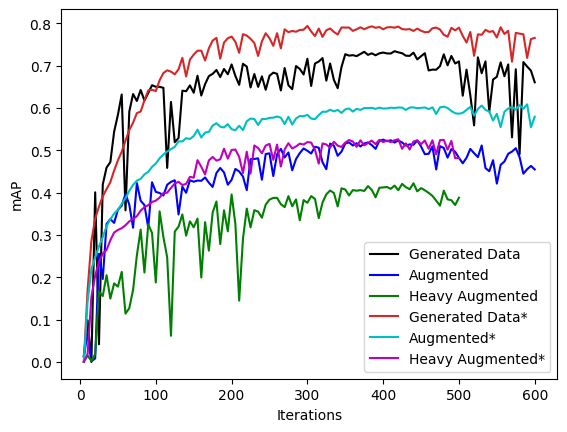

/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/norm_data/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data_bigger_pos/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/norm_data_with_augmentations/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data_with_augmentations/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/augmented_data_bigger_pos_with_augmentations/final


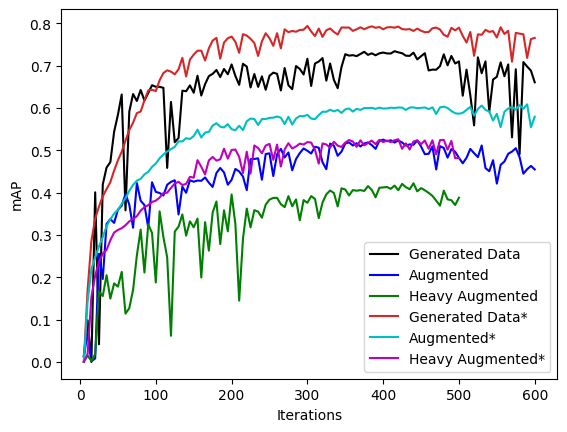

In [7]:
log_dir = "/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp"
# plot_value = "Val_metrics/AP_50"
plot_value = "Val_metrics/mAP"
experiments = ["old/Football/norm_data", "old/Football/augmented_data", "old/Football/augmented_data_bigger_pos", "old/Football/norm_data_with_augmentations", "old/Football/augmented_data_with_augmentations", "old/Football/augmented_data_bigger_pos_with_augmentations"]
graph_names = ["Generated Data", "Augmented", "Heavy Augmented", "Generated Data*", "Augmented*", "Heavy Augmented*"]
image_name = "generate_data_and_augmentations"

# experiments = ["old/Football/augmented_data_bigger_pos_with_augmentations", "old/Football/weight_averager_augmented_data_bigger_pos_with_augmentations", "old/Football/plus_weight_averager_augmented_data_bigger_pos_with_augmentations"]
# graph_names = ["Heavy Augmented*", "EMA Training", "Distillation Training"]
# image_name = "ema_teacher_50"

# experiments = ["old/Football/plus_weight_averager_augmented_data_bigger_pos_with_augmentations", "old/Football/plus_weight_averager_hinge_loss_augmented_data_bigger_pos_with_augmentations", "old/Football/plus_weight_averager_hinge_augmented_data_bigger_pos_with_augmentations"]
# graph_names = ["Distillation Training", "Hinge loss", "Hinge loss in SLA"]
# image_name = "hinge_loss"

# experiments = ["old/Football/plus_weight_averager_augmented_data_bigger_pos_with_augmentations", "old/Football/plus_weight_averager_augmented_data_bigger_pos_with_augmentations_pre16_2"]
# graph_names = ["Distillation Training", "Distillation Training FP16"]
# image_name = "precision_16"

colors = ["k", "b", "g", "tab:red", "c", "m", "y", "tab:orange", "tab:olive", "tab:pink", "tab:brown"]
ts_graphs = ["final"] *len(experiments)

combine_graphs_to_plot(log_dir, experiments, colors, ts_graphs, graph_names, plot_value, )


limits = [
    1.0,           # map_upper_value
    0.0,           # map_lower_value
    10000.0,       # step_upper_value
    0.0,           # step_lower_value
]
combine_graphs_to_plot(log_dir, experiments, colors, ts_graphs, graph_names, plot_value, True, image_name, limits=limits)#, y_label="AP@50")

/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/norm_data/final
/home/manos/Thesis/opendr/projects/python/perception/object_detection_2d/nanodet/temp/old/Football/norm_data_with_augmentations/final


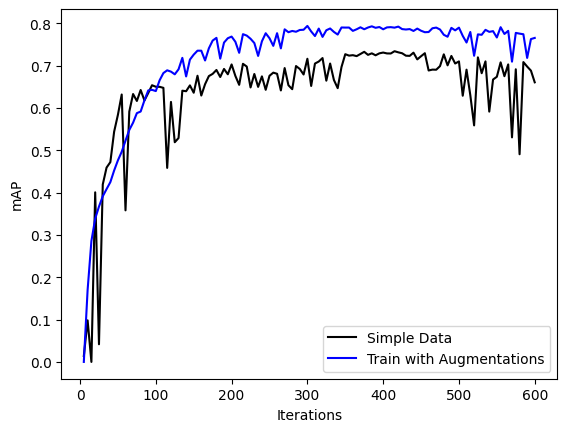

In [52]:
loc = 'lower right'
split_is_needed = True
map_upper_value = 1
map_lower_value = 0
step_upper_value = 10000
step_lower_value = 0

loc = 'lower right'
ts_graphs = [f"{log_dir}/{experiment}/{log_file}" for (experiment, log_file) in zip(experiments, ts_graphs)]

for ts_graph, graph_name, color in zip(ts_graphs, graph_names, colors):
    reader = SummaryReader(f"{ts_graph}")
    df = reader.scalars
    evaluation_df = df[df["tag"] == 'Val_metrics/mAP']
    if split_is_needed and (ts_graph == "s_four" or ts_graph == "s_three_"):
        _, evaluation_df = split_tensorboard_graphs(df, 'Val_metrics/mAP')
    evaluation_df = evaluation_df[evaluation_df["value"] <= map_upper_value]
    evaluation_df = evaluation_df[evaluation_df["value"] >= map_lower_value]
    evaluation_df = evaluation_df[evaluation_df["step"] <= step_upper_value]
    evaluation_df = evaluation_df[evaluation_df["step"] >= step_lower_value].reset_index(drop=True)
    plt.plot("step", "value", data=evaluation_df, label=graph_name, color=color)
plt.xlabel("Iterations")
plt.ylabel("mAP")
plt.legend(loc=loc)
plt.show()